In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
    #trumpler meta data
    trumpler_df = pd.DataFrame([
        ['Trumpler14', '10:43:55.4','-59:32:16', 2.37,0.15, 264, -6.58, 0.06, 2.185, 0.084],
        ['Trumpler15', '10:44:40.8', '-59:22:10', 2.36, 0.09, 320, np.nan, np.nan, np.nan, np.nan],
        ['Trumpler16', '10:45:10.6', '-59:42:28', 2.32,0.12, 320, -6.931,0.063, 2.612, 0.058]
    ], columns=['ClusterName','ra', 'dec','distance','disterr','radius','pm_ra_cosdec','pm_ra_cosdec_error','pm_dec','pm_dec_error']
    ).set_index('ClusterName')
    tc = SkyCoord(ra=trumpler_df.ra, dec=trumpler_df.dec,
        pm_ra_cosdec = list(trumpler_df.pm_ra_cosdec)*u.mas/u.year,
        pm_dec = list(trumpler_df.pm_dec)*u.mas/u.year,
        unit=(u.hourangle, u.deg),
        distance = list(trumpler_df.distance)*u.kpc)
    
    trumpler_coords = {}
    for i, cl in enumerate(trumpler_df.index):
        trumpler_coords[cl]=tc[i]


In [3]:
carina_known_members = pd.read_csv('./data/carina_members.csv', comment='#')

In [4]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [5]:
carina_members={}
#for cl in cluster_names:
for cl, cluster in carina_known_members.groupby('Cluster'):
    known_members = list(cluster['Gaia Number'])
    print(f'Fetching {cl}')
    carina_members[cl]  = gs(name = cl, description=f'{cl} sources from Shull table from Gaia eDR3')
    carina_members[cl].from_source_idlist(known_members,schema='gaiaedr3', query_type='sync')

Fetching Bochum11
Fetching Other
Fetching Trumpler14
Fetching Trumpler15
Fetching Trumpler16


In [6]:
from gaiastars import from_pickle

carina_search_results = from_pickle(f'./data/carina_search_results')

In [7]:
len(carina_search_results)

107081

In [13]:
BP_RP, M_G = carina_search_results.get_colors()
valid = np.logical_and(np.isfinite(BP_RP), np.isfinite(M_G))
bp_rp = BP_RP[valid]; m_g=M_G[valid]

In [15]:
h, xedges, yedges = np.histogram2d(bp_rp, m_g, bins=100)

In [11]:
np.isfinite(BP_RP).sum()

99493

In [12]:
np.isfinite(M_G).sum()

106935

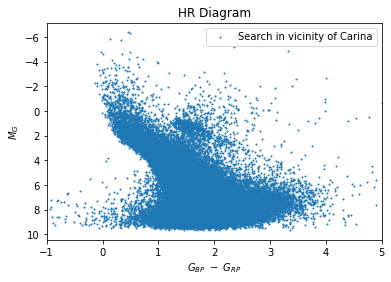

In [17]:
carina_search_results.plot_hrdiagram()

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(-1, 5)

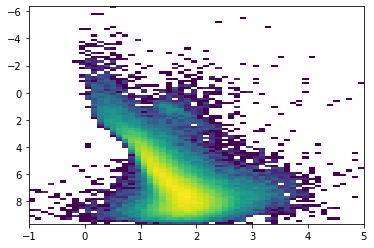

In [24]:
plt.imshow(np.log10(h.T), origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   aspect='auto', interpolation='nearest'
          )
plt.ylim(yedges[-1], yedges[0])
plt.xlim(-1,5)

In [26]:
len(carina_search_results), np.isfinite(carina_search_results.objs.pmra).sum(), np.isfinite(carina_search_results.objs.pmdec).sum()

(107081, 107081, 107081)

In [47]:
pm_h, pmra_edges, pmdec_edges = np.histogram2d(carina_search_results.objs.pmra, carina_search_results.objs.pmdec,
                                               range=np.array([[-10,0], [-2,6]]),
                                               bins=100)

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


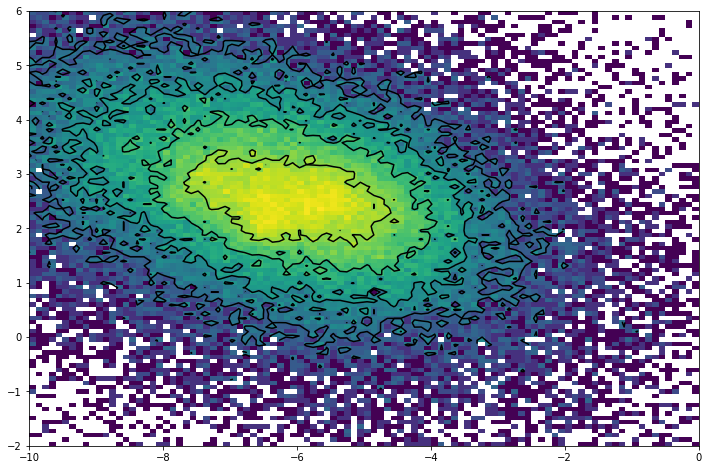

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.imshow(np.log10(pm_h.T), origin='lower',
    extent=[pmra_edges[0], pmra_edges[-1], pmdec_edges[0], pmdec_edges[-1]],
             aspect='auto',interpolation='nearest')
levels = np.linspace(0, np.log10(pm_h.max()), 7)[2:]
plt.contour(np.log10(pm_h.T), levels, colors='k',
            extent=[pmra_edges[0], pmra_edges[-1], pmdec_edges[0], pmdec_edges[-1]])